<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/W2D1-postcourse-bugfix/tutorials/W2D5_ReinforcementLearning/W2D5_Tutorial3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neuromatch Academy: Week 2, Day 5, Tutorial 3
# Learning to Act: Q-Learning

__Content creators:__ Marcelo Mattar and Eric DeWitt with help from Byron Galbraith

__Content reviewers:__ Matt Krause and Michael Waskom

---

# Tutorial Objectives
  
In this tutorial you will learn how to act in the more realistic setting of sequential decisions, formalized by Markov Decision Processes (MDPs). In a sequential decision problem, the actions executed in one state not only may lead to immediate rewards (as in a bandit problem), but may also affect the states experienced next (unlike a bandit problem). Each individual action may therefore affect affect all future rewards. Thus, making decisions in this setting requires considering each action in terms of their expected **cumulative** future reward.

We will consider here the example of spatial navigation, where actions (movements) in one state (location) affect the states experienced next, and an agent might need to execute a whole sequence of actions before a reward is obtained.

By the end of this tutorial, you will learn
* what grid worlds are and how they help in evaluating simple reinforcement learning agents
* the basics of the Q-learning algorithm for estimating action values
* how the concept of exploration and exploitation, reviewed in the bandit case, also applies to the sequential decision setting

---
# Setup

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve as conv

In [2]:
#@title Figure settings
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

In [3]:
#@title Helper functions
def epsilon_greedy(q, epsilon):
  """Epsilon-greedy policy: selects the maximum value action with probabilty
  (1-epsilon) and selects randomly with epsilon probability.

  Args:
    q (ndarray): an array of action values
    epsilon (float): probability of selecting an action randomly

  Returns:
    int: the chosen action
  """
  if np.random.random() > epsilon:
    action = np.argmax(q)
  else:
    action = np.random.choice(len(q))

  return action


class CliffWorld:
  """
  World: Cliff world.
  40 states (4-by-10 grid world).
  The mapping from state to the grids are as follows:
  30 31 32 ... 39
  20 21 22 ... 29
  10 11 12 ... 19
  0  1  2  ...  9
  0 is the starting state (S) and 9 is the goal state (G).
  Actions 0, 1, 2, 3 correspond to right, up, left, down.
  Moving anywhere from state 9 (goal state) will end the session.
  Taking action down at state 11-18 will go back to state 0 and incur a
      reward of -100.
  Landing in any states other than the goal state will incur a reward of -1.
  Going towards the border when already at the border will stay in the same
      place.
  """
  def __init__(self):
    self.name = "cliff_world"
    self.n_states = 40
    self.n_actions = 4
    self.dim_x = 10
    self.dim_y = 4
    self.init_state = 0

  def get_outcome(self, state, action):
    if state == 9:  # goal state
      reward = 0
      next_state = None
      return next_state, reward
    reward = -1  # default reward value
    if action == 0:  # move right
      next_state = state + 1
      if state % 10 == 9:  # right border
        next_state = state
      elif state == 0:  # start state (next state is cliff)
        next_state = None
        reward = -100
    elif action == 1:  # move up
      next_state = state + 10
      if state >= 30:  # top border
        next_state = state
    elif action == 2:  # move left
      next_state = state - 1
      if state % 10 == 0:  # left border
        next_state = state
    elif action == 3:  # move down
      next_state = state - 10
      if state >= 11 and state <= 18:  # next is cliff
        next_state = None
        reward = -100
      elif state <= 9:  # bottom border
        next_state = state
    else:
      print("Action must be between 0 and 3.")
      next_state = None
      reward = None
    return int(next_state) if next_state is not None else None, reward

  def get_all_outcomes(self):
    outcomes = {}
    for state in range(self.n_states):
      for action in range(self.n_actions):
        next_state, reward = self.get_outcome(state, action)
        outcomes[state, action] = [(1, next_state, reward)]
    return outcomes


def learn_environment(env, learning_rule, params, max_steps, n_episodes):
  # Start with a uniform value function
  value = np.ones((env.n_states, env.n_actions))

  # Run learning
  reward_sums = np.zeros(n_episodes)

  # Loop over episodes
  for episode in range(n_episodes):
    state = env.init_state  # initialize state
    reward_sum = 0

    for t in range(max_steps):
      # choose next action
      action = epsilon_greedy(value[state], params['epsilon'])

      # observe outcome of action on environment
      next_state, reward = env.get_outcome(state, action)

      # update value function
      value = learning_rule(state, action, reward, next_state, value, params)

      # sum rewards obtained
      reward_sum += reward

      if next_state is None:
          break  # episode ends
      state = next_state

    reward_sums[episode] = reward_sum

  return value, reward_sums


def plot_state_action_values(env, value, ax=None):
  """
  Generate plot showing value of each action at each state.
  """
  if ax is None:
    fig, ax = plt.subplots()

  for a in range(env.n_actions):
    ax.plot(range(env.n_states), value[:, a], marker='o', linestyle='--')
  ax.set(xlabel='States', ylabel='Values')
  ax.legend(['R','U','L','D'], loc='lower right')


def plot_quiver_max_action(env, value, ax=None):
  """
  Generate plot showing action of maximum value or maximum probability at
    each state (not for n-armed bandit or cheese_world).
  """
  if ax is None:
    fig, ax = plt.subplots()

  X = np.tile(np.arange(env.dim_x), [env.dim_y,1]) + 0.5
  Y = np.tile(np.arange(env.dim_y)[::-1][:,np.newaxis], [1,env.dim_x]) + 0.5
  which_max = np.reshape(value.argmax(axis=1), (env.dim_y,env.dim_x))
  which_max = which_max[::-1,:]
  U = np.zeros(X.shape)
  V = np.zeros(X.shape)
  U[which_max == 0] = 1
  V[which_max == 1] = 1
  U[which_max == 2] = -1
  V[which_max == 3] = -1

  ax.quiver(X, Y, U, V)
  ax.set(
      title='Maximum value/probability actions',
      xlim=[-0.5, env.dim_x+0.5],
      ylim=[-0.5, env.dim_y+0.5],
  )
  ax.set_xticks(np.linspace(0.5, env.dim_x-0.5, num=env.dim_x))
  ax.set_xticklabels(["%d" % x for x in np.arange(env.dim_x)])
  ax.set_xticks(np.arange(env.dim_x+1), minor=True)
  ax.set_yticks(np.linspace(0.5, env.dim_y-0.5, num=env.dim_y))
  ax.set_yticklabels(["%d" % y for y in np.arange(0, env.dim_y*env.dim_x,
                                                  env.dim_x)])
  ax.set_yticks(np.arange(env.dim_y+1), minor=True)
  ax.grid(which='minor',linestyle='-')


def plot_heatmap_max_val(env, value, ax=None):
  """
  Generate heatmap showing maximum value at each state
  """
  if ax is None:
    fig, ax = plt.subplots()

  if value.ndim == 1:
      value_max = np.reshape(value, (env.dim_y,env.dim_x))
  else:
      value_max = np.reshape(value.max(axis=1), (env.dim_y,env.dim_x))
  value_max = value_max[::-1,:]

  im = ax.imshow(value_max, aspect='auto', interpolation='none', cmap='afmhot')
  ax.set(title='Maximum value per state')
  ax.set_xticks(np.linspace(0, env.dim_x-1, num=env.dim_x))
  ax.set_xticklabels(["%d" % x for x in np.arange(env.dim_x)])
  ax.set_yticks(np.linspace(0, env.dim_y-1, num=env.dim_y))
  if env.name != 'windy_cliff_grid':
      ax.set_yticklabels(
          ["%d" % y for y in np.arange(
              0, env.dim_y*env.dim_x, env.dim_x)][::-1])
  return im


def plot_rewards(n_episodes, rewards, average_range=10, ax=None):
  """
  Generate plot showing total reward accumulated in each episode.
  """
  if ax is None:
    fig, ax = plt.subplots()

  smoothed_rewards = (conv(rewards, np.ones(average_range), mode='same')
                      / average_range)

  ax.plot(range(0, n_episodes, average_range),
          smoothed_rewards[0:n_episodes:average_range],
          marker='o', linestyle='--')
  ax.set(xlabel='Episodes', ylabel='Total reward')


def plot_performance(env, value, reward_sums):
  fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
  plot_state_action_values(env, value, ax=axes[0,0])
  plot_quiver_max_action(env, value, ax=axes[0,1])
  plot_rewards(n_episodes, reward_sums, ax=axes[1,0])
  im = plot_heatmap_max_val(env, value, ax=axes[1,1])
  fig.colorbar(im)

---
# Section 1: Markov Decision Processes

Video available at https://youtu.be/8yvwMrUQJOU


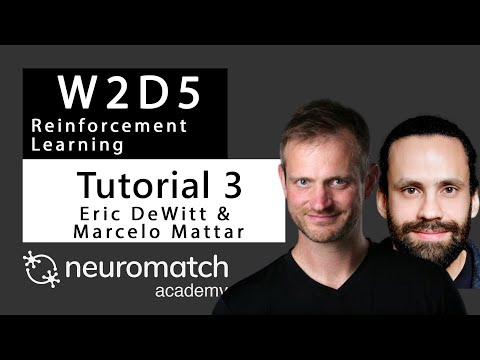

In [4]:
#@title Video 1: MDPs and Q-learning
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="8yvwMrUQJOU", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

## Section 1.1: Grid Worlds

As pointed out, bandits only have a single state and immediate rewards for our actions. Many problems we are interested in have multiple states and delayed rewards, i.e. we won't know if the choices we made will pay off over time, or which actions we took contributed to the outcomes we observed.

In order to explore these ideas, we turn the a common problem setting: the grid world. Grid worlds are simple environments where each state corresponds to a tile on a 2D grid, and the only actions the agent can take are to move up, down, left, or right across the grid tiles. The agent's job is almost always to find a way to a goal tile in the most direct way possible while overcoming some maze or other obstacles, either static or dynamic.

For our discussion we will be looking at the classic Cliff World, or Cliff Walker, environment. This is a 4x10 grid with a starting position in the lower-left and the goal position in the lower-right. Every tile between these two is the "cliff", and should the agent enter the cliff, they will receive a -100 reward and be sent back to the starting position. Every tile other than the cliff produces a -1 reward when entered. The goal tile ends the episode after taking any action from it.

<img alt="CliffWorld" width="577" height="308" src="https://github.com/NeuromatchAcademy/course-content/blob/master/tutorials/W2D5_ReinforcementLearning/static/W2D5_Tutorial3_CliffWorld.png?raw=true">

Given these conditions, the maximum achievable reward is -11 (1 up, 9 right, 1 down). Using negative rewards is a common technique to encourage the agent to move and seek out the goal state as fast as possible.

---
# Section 2: Q-Learning

Now that we have our environment, how can we solve it? 

One of the most famous algorithms for estimating action values (aka Q-values) is the Temporal Differences (TD) **control** algorithm known as *Q-learning* (Watkins, 1989). 

\begin{align}
Q(s_t,a_t) \leftarrow Q(s_t,a_t) + \alpha \big(r_t + \gamma\max_\limits{a} Q(s_{t+1},a_{t+1}) - Q(s_t,a_t)\big)
\end{align}

where $Q(s,a)$ is the value function for action $a$ at state $s$, $\alpha$ is the learning rate, $r$ is the reward, and $\gamma$ is the temporal discount rate.

The expression $r_t + \gamma\max_\limits{a} Q(s_{t+1},a_{t+1})$ is referred to as the TD target while the full expression 
\begin{align}
r_t + \gamma\max_\limits{a} Q(s_{t+1},a_{t+1}) - Q(s_t,a_t),
\end{align}
i.e. the difference between the TD target and the current Q-value, is referred to as the TD error, or reward prediction error.

Because of the max operator used to select the optimal Q-value in the TD target, Q-learning directly estimates the optimal action value, i.e. the cumulative future reward that would be obtained if the agent behaved optimally, regardless of the policy currently followed by the agent. For this reason, Q-learning is referred to as an **off-policy** method.

## Exercise 1: Implement the Q-learning algorithm

In this exercise you will implement the Q-learning update rule described above. It takes in as arguments the previous state $s_t$, the action $a_t$ taken, the reward received $r_t$, the current state $s_{t+1}$, the Q-value table, and a dictionary of parameters that contain the learning rate $\alpha$ and discount factor $\gamma$. The method returns the updated Q-value table. For the parameter dictionary, $\alpha$: `params['alpha']` and $\gamma$: `params['gamma']`. 


In [5]:
def q_learning(state, action, reward, next_state, value, params):
  """Q-learning: updates the value function and returns it.

  Args:
    state (int): the current state identifier
    action (int): the action taken
    reward (float): the reward received
    next_state (int): the transitioned to state identifier
    value (ndarray): current value function of shape (n_states, n_actions)
    params (dict): a dictionary containing the default parameters

  Returns:
    ndarray: the updated value function of shape (n_states, n_actions)
  """
  # Q-value of current state-action pair
  q = value[state, action]

  ##########################################################
  ## TODO for students: implement the Q-learning update rule
  # Fill out function and remove
  raise NotImplementedError("Student excercise: implement the Q-learning update rule")
  ##########################################################

  # write an expression for finding the maximum Q-value at the current state
  if next_state is None:
    max_next_q = 0
  else:
    max_next_q = ...

  # write the expression to compute the TD error
  td_error = ...
  # write the expression that updates the Q-value for the state-action pair
  value[state, action] = ...

  return value

In [6]:
# to_remove solution
def q_learning(state, action, reward, next_state, value, params):
  """Q-learning: updates the value function and returns it.

  Args:
    state (int): the current state identifier
    action (int): the action taken
    reward (float): the reward received
    next_state (int): the transitioned to state identifier
    value (ndarray): current value function of shape (n_states, n_actions)
    params (dict): a dictionary containing the default parameters

  Returns:
    ndarray: the updated value function of shape (n_states, n_actions)
  """
  # Q-value of current state-action pair
  q = value[state, action]

  # write an expression for finding the maximum Q-value at the current state
  if next_state is None:
    max_next_q = 0
  else:
    max_next_q = np.max(value[next_state])

  # write the expression to compute the TD error
  td_error = reward + params['gamma'] * max_next_q - q
  # write the expression that updates the Q-value for the state-action pair
  value[state, action] = q + params['alpha'] * td_error

  return value

Now that we have our Q-learning algorithm, let's see how it handles learning to solve the Cliff World environment. 

You will recall from the previous tutorial that a major part of reinforcement learning algorithms are their ability to balance exploitation and exploration. For our Q-learning agent, we again turn to the epsilon-greedy strategy. At each step, the agent will decide with probability $1 - \epsilon$ to use the best action for the state it is currently in by looking at the value function, otherwise just make a random choice.

The process by which our the agent will interact with and learn about the environment is handled for you in the helper function `learn_environment`. This implements the entire learning episode lifecycle of stepping through the state observation, action selection (epsilon-greedy) and execution, reward, and state transition. Feel free to review that code later to see how it all fits together, but for now let's test out our agent.

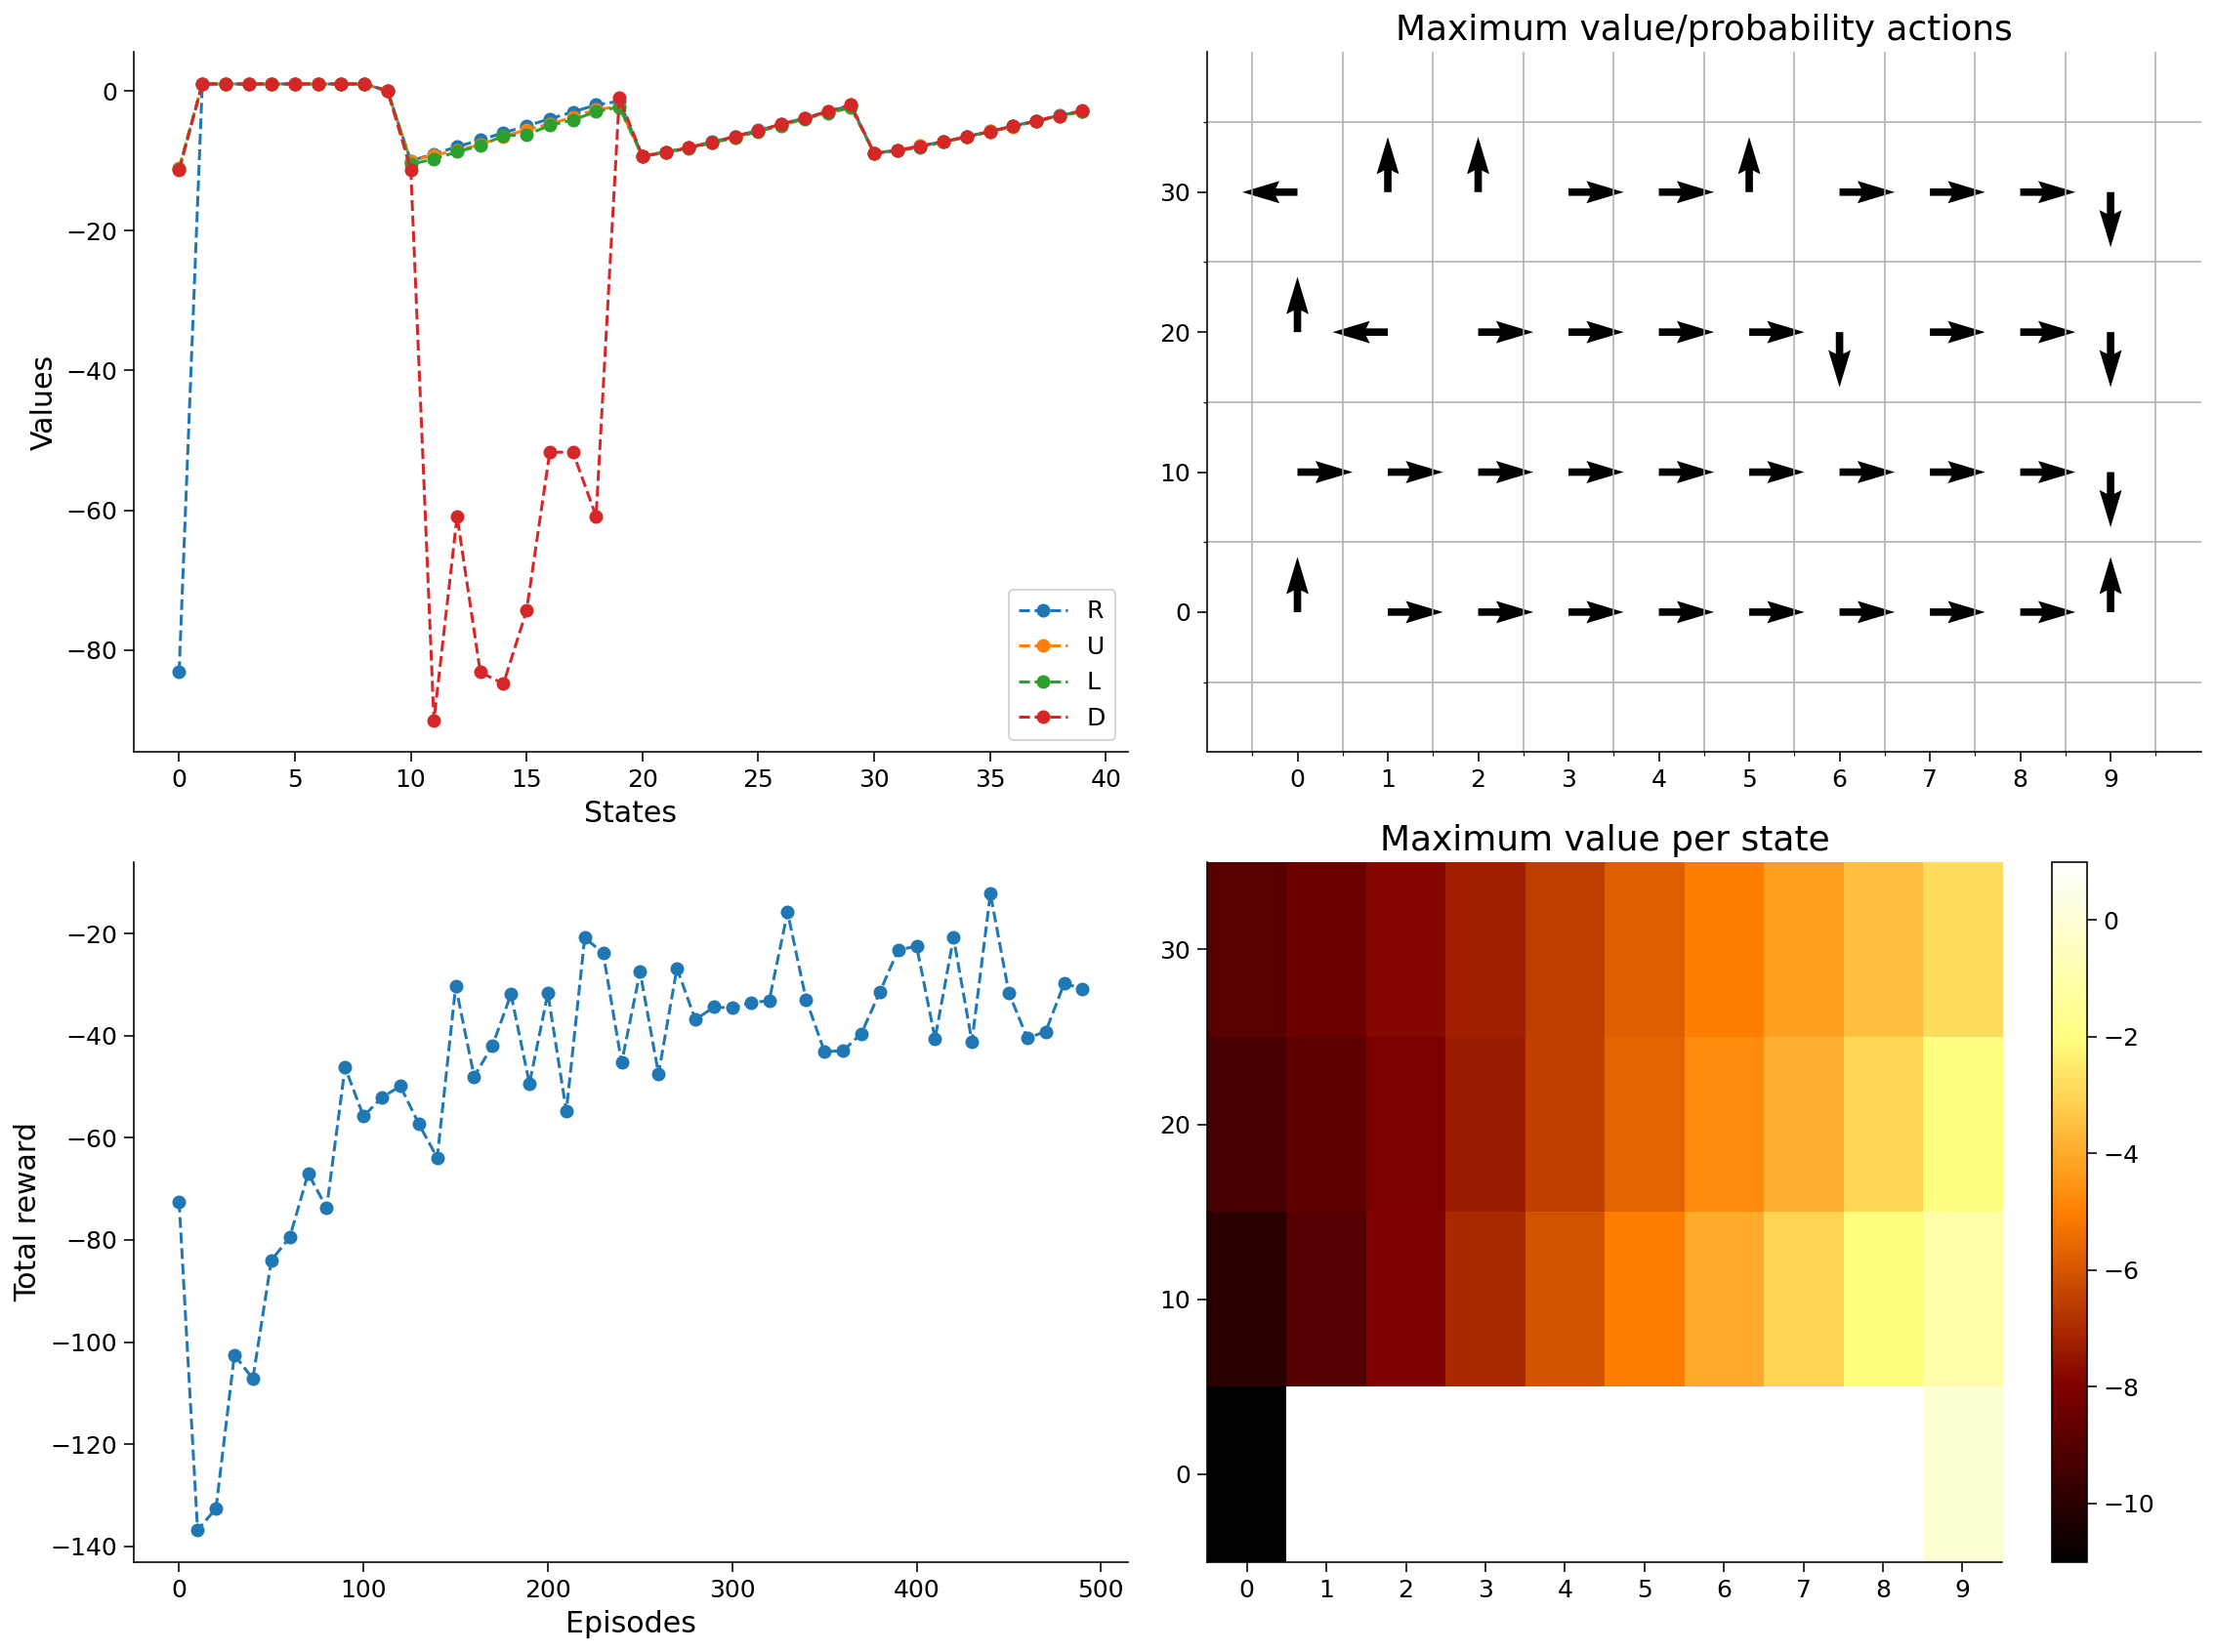

In [7]:
# set for reproducibility, comment out / change seed value for different results
np.random.seed(1)

# parameters needed by our policy and learning rule
params = {
  'epsilon': 0.1,  # epsilon-greedy policy
  'alpha': 0.1,  # learning rate
  'gamma': 1.0,  # discount factor
}

# episodes/trials
n_episodes = 500
max_steps = 1000

# environment initialization
env = CliffWorld()

# solve Cliff World using Q-learning
results = learn_environment(env, q_learning, params, max_steps, n_episodes)
value_qlearning, reward_sums_qlearning = results

# Plot results
plot_performance(env, value_qlearning, reward_sums_qlearning)

If all went well, we should see four plots that show different aspects on our agent's learning and progress.

* The top left is a representation of the Q-table itself, showing the values for different actions in different states. Notably, going right from the starting state or down when above the cliff is clearly very bad.
* The top right figure shows the greedy policy based on the Q-table, i.e. what action would the agent take if it only took its best guess in that state.
* The bottom right is the same as the top, only instead of showing the action, it's showing a representation of the maximum Q-value at a particular state.
* The bottom left is the actual proof of learning, as we see the total reward steadily increasing after each episode until asymptoting at the maximum possible reward of -11.

Feel free to try changing the parameters or random seed and see how the agent's behavior changes.

---
# Summary

In this tutorial you implemented a reinforcement learning agent based on Q-learning to solve the Cliff World environment. Q-learning combined the epsilon-greedy approach to exploration-expoitation with a table-based value function to learn the expected future rewards for each state.

---
# Bonus

## SARSA

An alternative to Q-learning, the SARSA algorithm also estimates action values. However, rather than estimating the optimal (off-policy) values, SARSA estimates the **on-policy** action value, i.e. the cumulative future reward that would be obtained if the agent behaved according to its current beliefs.

\begin{align}
Q(s_t,a_t) \leftarrow Q(s_t,a_t) + \alpha \big(r_t + \gamma Q(s_{t+1},a_{t+1}) - Q(s_t,a_t)\big)
\end{align}

where, once again, $Q(s,a)$ is the value function for action $a$ at state $s$, $\alpha$ is the learning rate, $r$ is the reward, and $\gamma$ is the temporal discount rate.

In fact, you will notices that the *only* difference between Q-learning and SARSA is the TD target calculation uses the policy to select the next action (in our case epsilon-greedy) rather than using the action that maximizes the Q-value.

### Exercise 2: Implement the SARSA algorithm

In this exercise you will implement the SARSA update rule described above. Just like Q-learning, it takes in as arguments the previous state $s_t$, the action $a_t$ taken, the reward received $r_t$, the current state $s_{t+1}$, the Q-value table, and a dictionary of parameters that contain the learning rate $\alpha$ and discount factor $\gamma$. The method returns the updated Q-value table. You may use the `epsilon_greedy` function to acquire the next action. For the parameter dictionary, $\alpha$: `params['alpha']`, $\gamma$: `params['gamma']`, and $\epsilon$: `params['epsilon']`. 


In [8]:
def sarsa(state, action, reward, next_state, value, params):
  """SARSA: updates the value function and returns it.

  Args:
    state (int): the current state identifier
    action (int): the action taken
    reward (float): the reward received
    next_state (int): the transitioned to state identifier
    value (ndarray): current value function of shape (n_states, n_actions)
    params (dict): a dictionary containing the default parameters

  Returns:
    ndarray: the updated value function of shape (n_states, n_actions)
  """
  # value of previous state-action pair
  q = value[state, action]

  ##########################################################
  ## TODO for students: implement the SARSA update rule
  # Fill out function and remove
  raise NotImplementedError("Student excercise: implement the SARSA update rule")
  ##########################################################

  # select the expected value at current state based on our policy by sampling
  # from it
  if next_state is None:
    policy_next_q = 0
  else:
    # write an expression for selecting an action using epsilon-greedy
    policy_action = ...
    # write an expression for obtaining the value of the policy action at the
    # current state
    policy_next_q = ...

  # write the expression to compute the TD error
  td_error = ...
  # write the expression that updates the Q-value for the state-action pair
  value[state, action] = ...

  return value

In [9]:
def sarsa(state, action, reward, next_state, value, params):
  """SARSA: updates the value function and returns it.

  Args:
    state (int): the current state identifier
    action (int): the action taken
    reward (float): the reward received
    next_state (int): the transitioned to state identifier
    value (ndarray): current value function of shape (n_states, n_actions)
    params (dict): a dictionary containing the default parameters

  Returns:
    ndarray: the updated value function of shape (n_states, n_actions)
  """
  # value of previous state-action pair
  q = value[state, action]

  # select the expected value at current state based on our policy by sampling
  # from it
  if next_state is None:
    policy_next_q = 0
  else:
    # write an expression for selecting an action using epsilon-greedy
    policy_action = epsilon_greedy(value[next_state], params['epsilon'])
    # write an expression for obtaining the value of the policy action at the
    # current state
    policy_next_q = value[next_state, policy_action]

  # write the expression to compute the TD error
  td_error = reward + params['gamma'] * policy_next_q - q
  # write the expression that updates the Q-value for the state-action pair
  value[state, action] = q + params['alpha'] * td_error

  return value

Now that we have an implementation for SARSA, let's see how it tackles Cliff World. We will again use the same setup we tried with Q-learning.

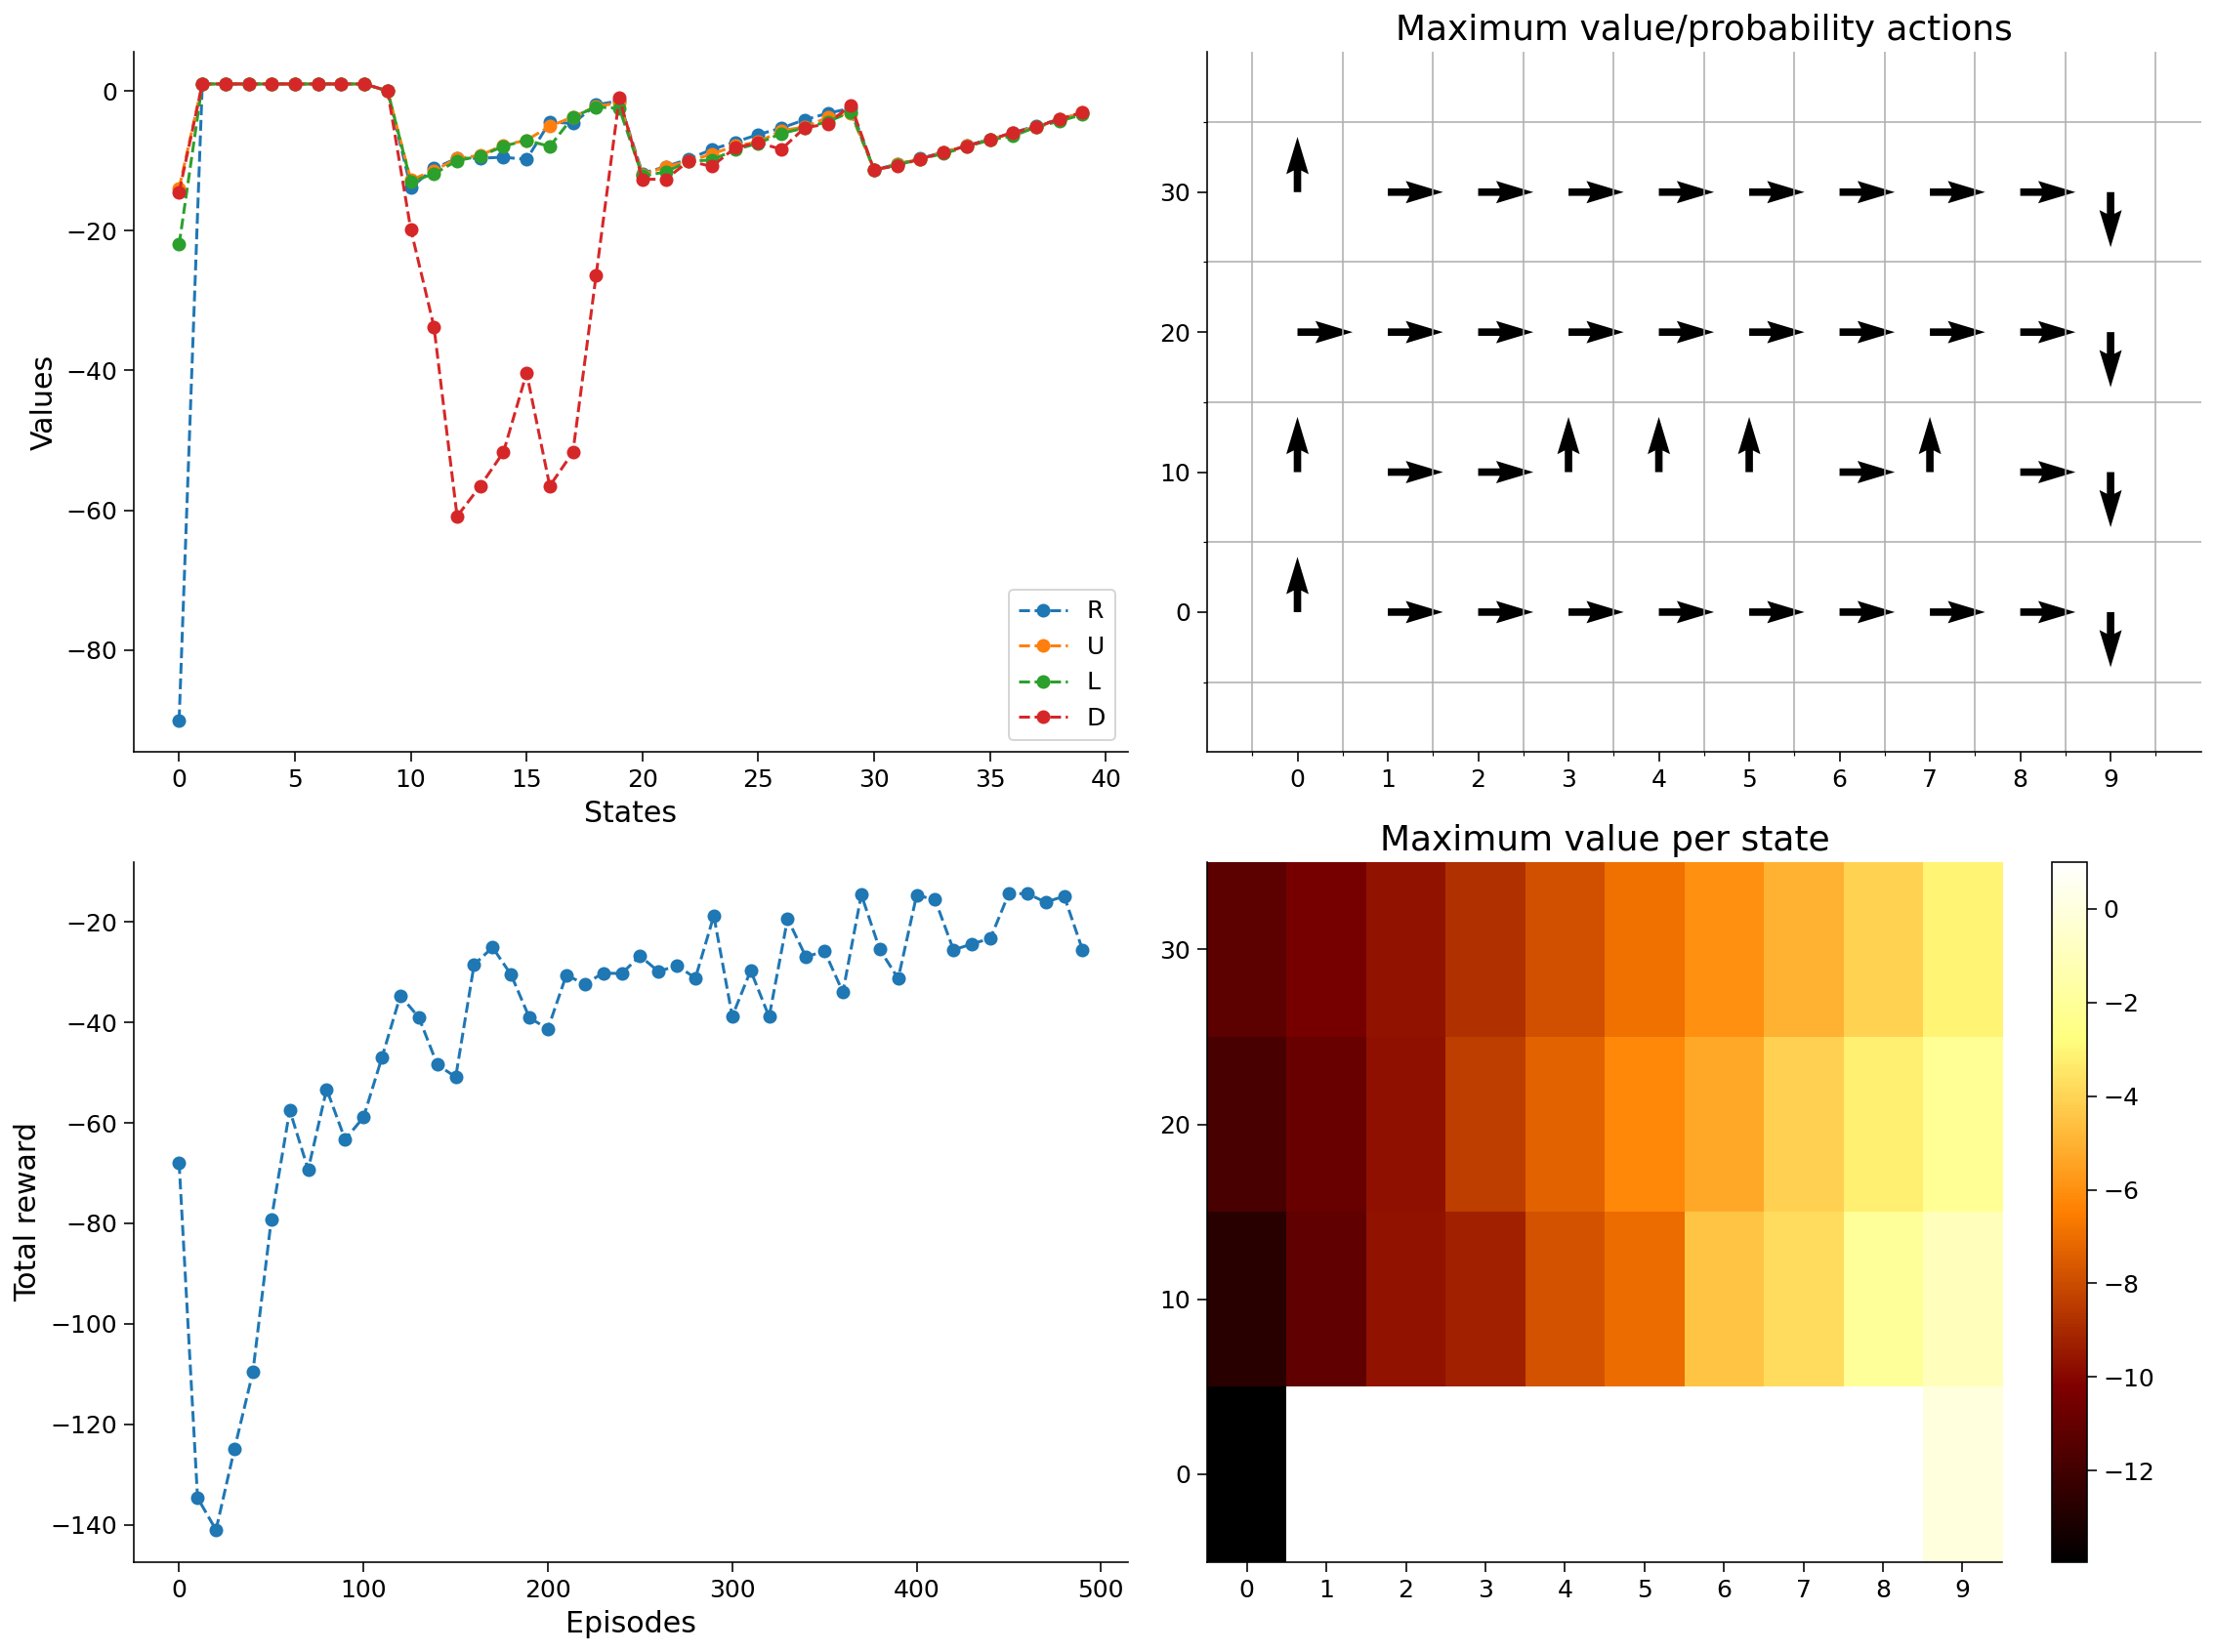

In [10]:
# set for reproducibility, comment out / change seed value for different results
np.random.seed(1)

# parameters needed by our policy and learning rule
params = {
  'epsilon': 0.1,  # epsilon-greedy policy
  'alpha': 0.1,  # learning rate
  'gamma': 1.0,  # discount factor
}

# episodes/trials
n_episodes = 500
max_steps = 1000

# environment initialization
env = CliffWorld()

# learn Cliff World using Sarsa
results = learn_environment(env, sarsa, params, max_steps, n_episodes)
value_sarsa, reward_sums_sarsa = results

# Plot results
plot_performance(env, value_sarsa, reward_sums_sarsa)

We should see that SARSA also solves the task with similar looking outcomes to Q-learning. One notable difference is that SARSA seems to be skittsh around the cliff edge and often goes further away before coming back down to the goal.

Again, feel free to try changing the parameters or random seed and see how the agent's behavior changes.

## On-Policy vs Off-Policy
   
We have now seen an example of both on- and off-policy learning algorithms. Let's compare both Q-learning and SARSA reward results again, side-by-side, to see how they stack up.

In [11]:
# parameters needed by our policy and learning rule
params = {
  'epsilon': 0.1,  # epsilon-greedy policy
  'alpha': 0.1,  # learning rate
  'gamma': 1.0,  # discount factor
}

# episodes/trials
n_episodes = 500
max_steps = 1000

# environment initialization
env = CliffWorld()

# learn Cliff World using Sarsa
np.random.seed(1)
results = learn_environment(env, q_learning, params, max_steps, n_episodes)
value_qlearning, reward_sums_qlearning = results
np.random.seed(1)
results = learn_environment(env, sarsa, params, max_steps, n_episodes)
value_sarsa, reward_sums_sarsa = results

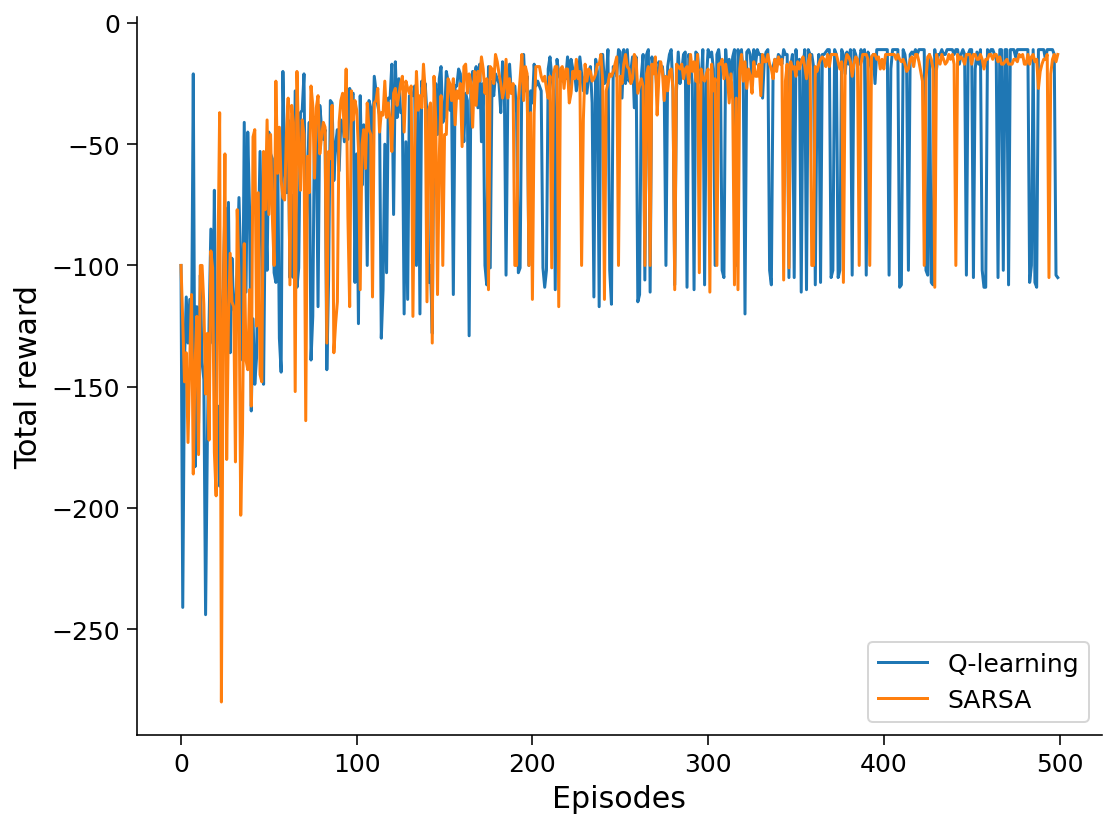

In [12]:
fig, ax = plt.subplots()
ax.plot(reward_sums_qlearning, label='Q-learning')
ax.plot(reward_sums_sarsa, label='SARSA')
ax.set(xlabel='Episodes', ylabel='Total reward')
plt.legend(loc='lower right');

On this simple Cliff World task, Q-learning and SARSA are almost indistinguisable from a performance standpoint, but we can see that Q-learning has a slight-edge within the 500 episode time horizon. Let's look at the illustrated "greedy policy" plots again.

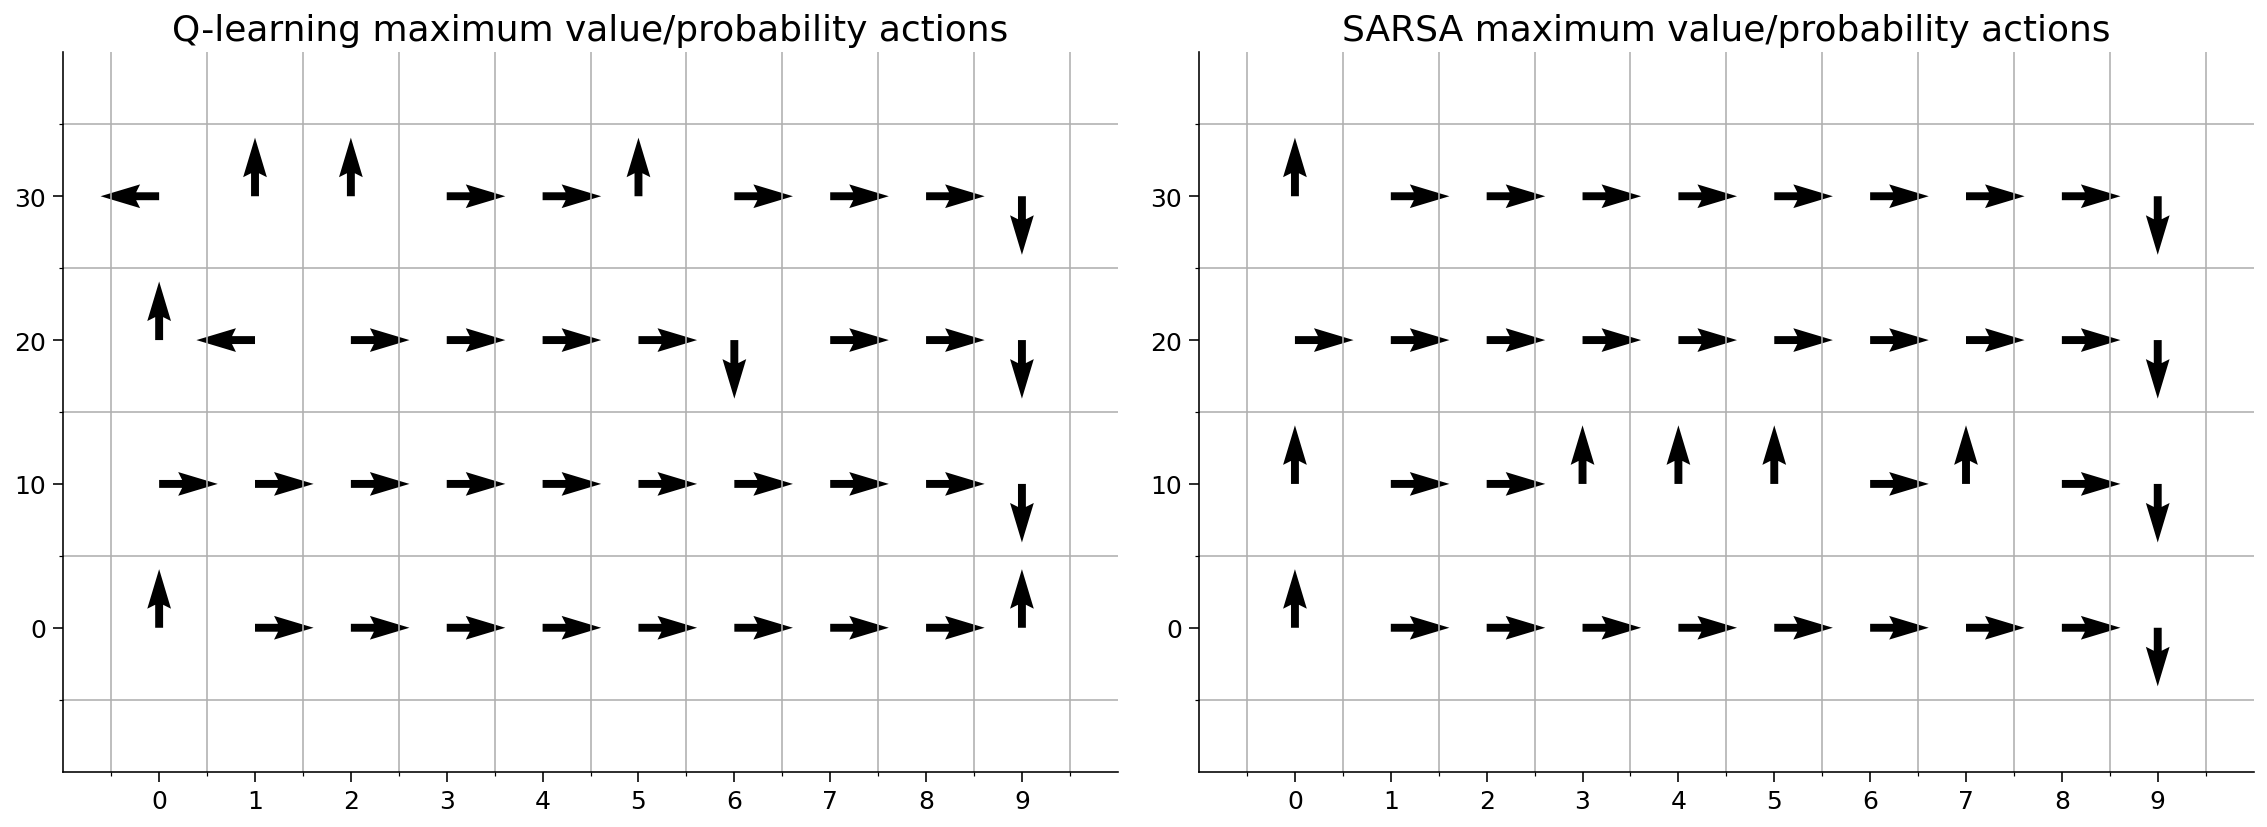

In [13]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 6))
plot_quiver_max_action(env, value_qlearning, ax=ax1)
ax1.set(title='Q-learning maximum value/probability actions')
plot_quiver_max_action(env, value_sarsa, ax=ax2)
ax2.set(title='SARSA maximum value/probability actions');

What should immediately jump out is that Q-learning learned to go up, then immediately go to the right, skirting the cliff edge, until it hits the wall and goes down to the goal. The policy further away from the cliff is less certain.

SARSA, on the other hand, appears to avoid the cliff edge, going up one more tile before starting over to the goal side. This also clearly solves the challenge of getting to the goal, but does so at an additional -2 cost over the truly optimal route.

Why do you think these behaviors emerged the way they did?